In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

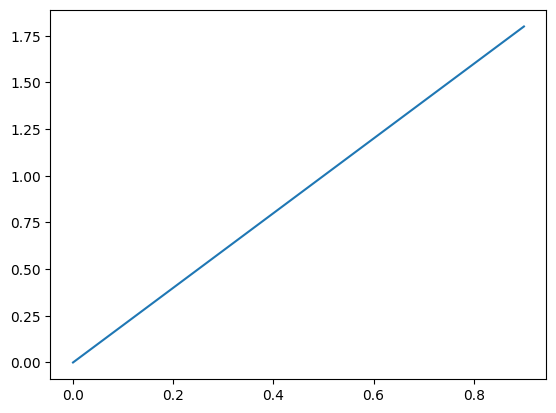

In [2]:
plt.plot(np.arange(0, 1, 0.1), 2*np.arange(0, 1, 0.1))

In [3]:
import h5py

In [4]:
from scipy.stats import norm

In [5]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch import nn, optim
import scipy.io as sio
# import pandas as pd
import datetime
import os
# import readligo as rl
# from gwpy.timeseries import TimeSeries
import math
import random

import copy

In [6]:
os.chdir('D:\OneDrive - HKUST Connect\Research\GWNMMAD\Codes')

FileNotFoundError: [WinError 2] 系统找不到指定的文件。: 'D:\\OneDrive - HKUST Connect\\Research\\GWNMMAD\\Codes'

In [7]:
import torch.nn.functional as F

In [8]:
epochs_wsl = 100;

In [9]:
epochs = 100
rTrain = 0.7;
rTest = 0.2;
# input_vector_length = 100
batch_size = 32
num_bins = 40
coef_delta = 0

# 4-AE + WSL

## Networks

In [9]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(101, 20),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 101),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [34]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(202, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 20),
            nn.ReLU(),
            nn.Linear(20, 202),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [43]:
class WSClassifier(nn.Module):
    def __init__(self):
        super(WSClassifier, self).__init__()
        self.fc1 = nn.Linear(101, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.norm1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 8)
        self.norm2 = nn.BatchNorm1d(8)
        self.fc4 = nn.Linear(8, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.norm1(self.relu(self.fc1(x)))
        x = self.norm2(self.relu(self.fc2(x)))
        return self.fc4(x)
        # x = self.relu(x)
#         x = self.sigmoid(x)

In [10]:
class WSClassifier(nn.Module):
    def __init__(self):
        super(WSClassifier, self).__init__()
        self.fc1 = nn.Linear(101, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.norm1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 1)
        # self.norm2 = nn.BatchNorm1d(8)
        # self.fc4 = nn.Linear(8, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        # nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.norm1(self.relu(self.fc1(x)))
        return self.fc2(x)
        # x = self.relu(x)
#         x = self.sigmoid(x)

In [10]:
class WSClassifier(nn.Module):
    def __init__(self):
        super(WSClassifier, self).__init__()
        self.fc1 = nn.Linear(202, 32)  # 第一层全连接层，输入维度为4，输出维度为64
        self.norm1 = nn.BatchNorm1d(32)
        self.relu = nn.ReLU()  # 激活函数
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(32, 1)
        # self.norm2 = nn.BatchNorm1d(8)
        # self.fc4 = nn.Linear(8, 1)  # 第三层全连接层，输入维度为32，输出维度为类别数目
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        # nn.init.kaiming_normal_(self.fc4.weight)

    def forward(self, x):
        x = self.norm1(self.relu(self.fc1(x)))
        return self.fc2(x)
        # x = self.relu(x)
#         x = self.sigmoid(x)

In [12]:
ae = AutoEncoder().cuda()
print(sum(p.numel() for p in ae.parameters() if p.requires_grad))

8732


In [13]:
wsc = WSClassifier().cuda()
print(sum(p.numel() for p in wsc.parameters() if p.requires_grad))

6593


In [13]:
wsc

WSClassifier(
  (fc1): Linear(in_features=202, out_features=32, bias=True)
  (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

## data loading

In [45]:
list_datatype = ["noise", "bbh", "sg", "glitch"]

In [46]:
N_wsl_total = 3000;
N_wsl = {}
N_wsl["noise"] = int(0.75*N_wsl_total)
N_wsl["bbh"] = int(0.1*N_wsl_total)
N_wsl["sg"] = int(0.1*N_wsl_total)
N_wsl["glitch"] = int(0.05*N_wsl_total)

In [68]:
renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/background.npz')['data'].reshape(-1,200) / renorm_factor_0;
realbbh = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy').reshape(-1,200) / renorm_factor_0;

realsg = np.load('E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy').reshape(-1,200) / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch_L = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1

In [47]:
## If one is using Chia-Jui's data

renorm_factor_0 = 20;
renorm_factor_1 = 20;

realbkg_L = np.load('../Data_cached/real_bkg_2202000_63917s_4000Hz_50ms.npy')[:1000000].reshape(-1,1,200) / renorm_factor_0;
realbkg_H = np.load('../Data_cached/real_bkg_H_1466640_58803s_4000Hz_50ms.npy')[:1000000].reshape(-1,1,200) / renorm_factor_0;

realbkg = np.concatenate((realbkg_L, realbkg_H), axis = 1).reshape(-1,200)

realbbh = np.load('../Data_cached/injected_BBH_1823_around_merger_time_63917_58803.npz')['strain'].reshape(-1,200) / renorm_factor_0;

realsg = np.load('../Data_cached/injected_lfsg_1835_around_merger_time_63917_58803.npz')['strain'].reshape(-1,200) / renorm_factor_0;
# realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
realglitch_L = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1
realglitch_H = np.load('../Data_cached/real_glitches_H_snrlt5_59732_4000Hz_25ms.npz')["strain_time_data"][:30000].reshape(-1,1,200) / renorm_factor_1

In [48]:
noise_first50k = realbkg.reshape(-1,2,200)[:30000]

glitch_L_noise_H = np.concatenate((realglitch_L, noise_first50k[:,[1],:]), axis = 1)
glitch_H_noise_L = np.concatenate((realglitch_H, noise_first50k[:,[0],:]), axis = 1)
realglitch = np.vstack((glitch_L_noise_H, glitch_H_noise_L))
np.random.shuffle(realglitch)
realglitch = realglitch.reshape(-1,200)
realbkg = realbkg[60000:]

In [49]:
realbkg_reserved = realbkg[-int(0.2 * len(realbkg)):]
realbbh_reserved = realbbh[-int(0.2 * len(realbbh)):]
realsg_reserved = realsg[-int(0.2 * len(realsg)):]
realglitch_reserved = realglitch[-int(0.2 * len(realglitch)):]

realbkg = realbkg[:-int(0.2 * len(realbkg))]
realbbh = realbbh[:-int(0.2 * len(realbbh))-int(0.2 * len(realbbh))%2]
realsg = realsg[:-int(0.2 * len(realsg))-int(0.2 * len(realsg))%2]
realglitch = realglitch[:-int(0.2 * len(realglitch))]

In [50]:
bkg_fft = abs(np.fft.rfft(realbkg))
bkg_fft = bkg_fft/np.linalg.norm([bkg_fft], axis=2).T

bbh_fft = abs(np.fft.rfft(realbbh))
bbh_fft = bbh_fft/np.linalg.norm([bbh_fft], axis=2).T

sg_fft = abs(np.fft.rfft(realsg))
sg_fft = sg_fft/np.linalg.norm([sg_fft], axis=2).T

glitch_fft = abs(np.fft.rfft(realglitch))
glitch_fft = glitch_fft/np.linalg.norm([glitch_fft], axis=2).T

In [51]:
bkg_fft.shape

(1552000, 101)

In [52]:
glitch_fft.shape

(96000, 101)

In [53]:
bbh_fft.shape

(2916, 101)

In [54]:
bkg_fft = bkg_fft.reshape(-1,202)

bbh_fft = bbh_fft.reshape(-1,202)

sg_fft = sg_fft.reshape(-1,202)

glitch_fft = glitch_fft.reshape(-1,202)

In [55]:
del realbkg_L, realbkg_H, realglitch_L, realglitch_H, glitch_L_noise_H, glitch_H_noise_L

In [59]:
# dataset_raw = {};
# dataset_raw["noise"] = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/background.npz")['data'].reshape(-1,200);
# dataset_raw["bbh"] = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/bbh_for_challenge.npy").reshape(-1,200);
# dataset_raw["sg"] = np.load("E://GWNMMAD_data/Tw_dataset/Datasets/sglf_for_challenge.npy").reshape(-1,200);
# # realglitch = np.load("../data/real_glitches_9998_4000Hz_25ms.npz")["strain_time_data"]
# dataset_raw["glitch"] = np.load("../Data_cached/real_glitches_snrlt5_60132_4000Hz_25ms.npz")["strain_time_data"]

# dataset_wsl = {};
# dataset_ae = {};
# dataset_wsl_fft = {};
# dataset_ae_fft = {};

# for dt in list_datatype:
#     perm = np.random.permutation(len(dataset_raw[dt]))
#     nwsl = N_wsl[dt]
#     dataset_wsl[dt] = dataset_raw[dt][perm[:nwsl]]
#     dataset_wsl[dt] = dataset_wsl[dt] / np.linalg.norm([dataset_wsl[dt]], axis=2).T
#     dataset_wsl_fft[dt] = abs(np.fft.rfft(dataset_wsl[dt]))
#     dataset_wsl_fft[dt] = dataset_wsl_fft[dt]/np.linalg.norm([dataset_wsl_fft[dt]], axis=2).T
    
#     dataset_ae[dt]  = dataset_raw[dt][perm[nwsl:]]
#     dataset_ae[dt] = dataset_ae[dt] / np.linalg.norm([dataset_ae[dt]], axis=2).T
#     dataset_ae_fft[dt] = abs(np.fft.rfft(dataset_ae[dt]))
#     dataset_ae_fft[dt] = dataset_ae_fft[dt]/np.linalg.norm([dataset_ae_fft[dt]], axis=2).T
    
#     np.savetxt("../Data_Cached/SequentialTraining/WSL/perm_"+dt+"_2det.dat", perm)

In [56]:
dataset_raw_fft = {}

dataset_raw_fft["noise"] = bkg_fft
dataset_raw_fft["bbh"] = bbh_fft
dataset_raw_fft["sg"] = sg_fft
dataset_raw_fft["glitch"] = glitch_fft

dataset_wsl = {};
dataset_ae = {};
dataset_wsl_fft = {};
dataset_ae_fft = {};

for dt in list_datatype:
    perm = np.random.permutation(len(dataset_raw_fft[dt]))
    nwsl = N_wsl[dt]
    dataset_wsl_fft[dt] = dataset_raw_fft[dt][perm[:nwsl]]
    # dataset_wsl[dt] = dataset_wsl[dt] / np.linalg.norm([dataset_wsl[dt]], axis=2).T
    # dataset_wsl_fft[dt] = abs(np.fft.rfft(dataset_wsl[dt]))
    # dataset_wsl_fft[dt] = dataset_wsl_fft[dt]/np.linalg.norm([dataset_wsl_fft[dt]], axis=2).T
    
    dataset_ae_fft[dt]  = dataset_raw_fft[dt][perm[nwsl:]]
    # dataset_ae[dt] = dataset_ae[dt] / np.linalg.norm([dataset_ae[dt]], axis=2).T
    # dataset_ae_fft[dt] = abs(np.fft.rfft(dataset_ae[dt]))
    # dataset_ae_fft[dt] = dataset_ae_fft[dt]/np.linalg.norm([dataset_ae_fft[dt]], axis=2).T
    
    np.savetxt("../Data_Cached/SequentialTraining/WSL/perm_"+dt+"_2det_Chia-Jui_"+version+"_2.dat", perm)

In [57]:
np.linalg.norm(dataset_ae_fft['noise'][0])

1.4142135623730951

In [58]:
for key in dataset_ae_fft.keys():
    print(key)
    print(dataset_ae_fft[key].shape)

noise
(773750, 202)
bbh
(1158, 202)
sg
(1168, 202)
glitch
(47850, 202)


In [106]:
for key in dataset_wsl_fft.keys():
    print(key)
    print(dataset_wsl_fft[key].shape)

noise
(2250, 202)
bbh
(300, 202)
sg
(300, 202)
glitch
(150, 202)


In [29]:
bkg_reserved_fft = abs(np.fft.rfft(realbkg_reserved))
bkg_reserved_fft = bkg_reserved_fft/np.linalg.norm([bkg_reserved_fft], axis=2).T

bbh_reserved_fft = abs(np.fft.rfft(realbbh_reserved))
bbh_reserved_fft = bbh_reserved_fft/np.linalg.norm([bbh_reserved_fft], axis=2).T

sg_reserved_fft = abs(np.fft.rfft(realsg_reserved))
sg_reserved_fft = sg_reserved_fft/np.linalg.norm([sg_reserved_fft], axis=2).T

glitch_reserved_fft = abs(np.fft.rfft(realglitch_reserved))
glitch_reserved_fft = glitch_reserved_fft/np.linalg.norm([glitch_reserved_fft], axis=2).T

In [30]:
bkg_reserved_fft = bkg_reserved_fft.reshape(-1,202)

bbh_reserved_fft = bbh_reserved_fft.reshape(-1,202)

sg_reserved_fft = sg_reserved_fft.reshape(-1,202)

glitch_reserved_fft = glitch_reserved_fft.reshape(-1,202)

ValueError: cannot reshape array of size 73629 into shape (202)

In [59]:
N_reserved_test = {}

N_reserved_test_total = 20000

N_reserved_test['glitch'] = int(0.05 * N_reserved_test_total)
N_reserved_test['noise'] = int(0.65 * N_reserved_test_total)
N_reserved_test['bbh'] = int(0.15 * N_reserved_test_total)
N_reserved_test['sg'] = int(0.15 * N_reserved_test_total)

dataset_reserved_test_collected = np.vstack((glitch_reserved_fft[:N_reserved_test['glitch']], bkg_reserved_fft[:N_reserved_test['noise']],
                                             bbh_reserved_fft[:N_reserved_test['bbh']], sg_reserved_fft[:N_reserved_test['sg']]))

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 101 and the array at index 1 has size 202

In [31]:
dataset_reserved_test_collected.shape

NameError: name 'dataset_reserved_test_collected' is not defined

## training

In [62]:
version = "v7";

In [63]:
epochs = 50;

In [61]:
sequence = ["glitch", "noise", "bbh", "sg"];
ind2datatype = {};
datatype2ind = {};
for i, dt in enumerate(sequence):
    ind2datatype[i] = dt;
    datatype2ind[dt] = i;
    
torch.save(ind2datatype, "../Data_cached/SequentialTraining/WSL/sequence_"+version+".json")

In [60]:
dataset_wsl_fft_collected = np.empty((0, dataset_wsl_fft["glitch"].shape[1]))
for dt in sequence:
    dataset_wsl_fft_collected = np.vstack((dataset_wsl_fft_collected, dataset_wsl_fft[dt]))

In [30]:
# N_bkg = len(bkg_reserved_fft);
# N_glitch = int(N_bkg/15);
# N_bbh = int(N_bkg*2/15);
# N_sg = int(N_bkg*2/15);

# testset = np.empty((N_bkg+N_glitch+N_bbh+N_sg, len(bkg_reserved_fft[0])))

# s = 0;
# testset[s : s+N_glitch] = glitch_reserved_fft[np.random.permutation(len(glitch_reserved_fft))[:N_glitch]];
# s += N_glitch;

# testset[s : s+N_bkg] = bkg_reserved_fft[np.random.permutation(len(bkg_reserved_fft))[:N_bkg]];
# s += N_bkg;

# testset[s : s+N_bbh] = bbh_reserved_fft[np.random.permutation(len(bbh_reserved_fft))[:N_bbh]];
# s += N_bbh;

# testset[s : s+N_sg] = sg_reserved_fft[np.random.permutation(len(sg_reserved_fft))[:N_sg]];
# s += N_sg;

# correct_ans = np.concatenate(([0]*N_glitch, [1]*N_bkg, [2]*N_bbh, [3]*N_sg))

# Nsample = {};
# Nsample["glitch"] = N_glitch;
# Nsample["noise"] = N_bkg;
# Nsample["bbh"] = N_bbh;
# Nsample["sg"] = N_sg

In [31]:
# Ncut = 5;
# cutList = {};

# max_glitch = 0.0026;
# min_glitch = 0.001;
# cutList["glitch"] = np.linspace(min_glitch, max_glitch, Ncut);

# max_bkg = 0.0026;
# min_bkg = 0.001;
# cutList["noise"] = np.linspace(min_bkg, max_bkg, Ncut);

# max_bbh = 0.0024;
# min_bbh = 0.0008;
# cutList["bbh"] = np.linspace(min_bbh, max_bbh, Ncut);

# max_sg = 0.003;
# min_sg = 0.0003;
# cutList["sg"] = np.linspace(min_sg, max_sg, Ncut);

# torch.save(cutList, "../Data_cached/SequentialTraining/WSL/cut_"+version+".json")

In [34]:
Ncut = 5;
cutList = {};

max_glitch = 0.001;
min_glitch = 0.0024;
cutList["glitch"] = np.linspace(min_glitch, max_glitch, Ncut);

max_bkg = 0.0008;
min_bkg = 0.0018;
cutList["noise"] = np.linspace(min_bkg, max_bkg, Ncut);

max_bbh = 0.0014;
min_bbh = 0.0024;
cutList["bbh"] = np.linspace(min_bbh, max_bbh, Ncut);

max_sg = 0.0008;
min_sg = 0.0032;
cutList["sg"] = np.linspace(min_sg, max_sg, Ncut);

torch.save(cutList, "../Data_cached/SequentialTraining/WSL/cut_"+version+".json")

In [33]:
# models = {};
# models["glitch"] = torch.load("../Model_cached/4ae_3.pt")
# models["glitch"].cpu().eval()

In [35]:
models = {};
models["glitch"] = torch.load('../Model_cached/2_det_oneglitchonenoise_Chia-Jui_glitch_trained_202-20-202.pt')
models["glitch"].cpu().eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=202, out_features=20, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=202, bias=True)
    (1): Sigmoid()
  )
)

In [36]:
def trainAE(dataset, cutID, version, datatype):
    
    nTotal = len(dataset);
    nTrain = int(rTrain * nTotal)
    nTest = int(rTest * nTotal)

    X_train = dataset[:nTrain]
    X_test = dataset[-nTest:]
    X_validation = dataset[nTrain:-nTest]

    trainData = torch.FloatTensor(X_train)
    testData = torch.FloatTensor(X_test)
    validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(trainData)
    test_dataset = TensorDataset(testData)
    validation_dataset = TensorDataset(validationData)

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True)

    autoencoder = AutoEncoder().cuda()
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.00005)
    loss_func = nn.MSELoss().cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):

        autoencoder.train()
        for batchidx, x in enumerate(trainDataLoader):
            x = x[0].cuda()
            encoded, decoded = autoencoder(x)
            loss_overall = loss_func(decoded, x)
            weighted_lossTrain = loss_overall

            optimizer.zero_grad()
            weighted_lossTrain.backward()
            optimizer.step()
            
        autoencoder.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, x in enumerate(validationDataLoader):
                x = x[0].cuda()
                encoded, decoded = autoencoder(x)
                lossVal = loss_func(decoded, x)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = weighted_lossTrain.item()
        loss_validation[epoch] = val_loss
    
    autoencoder.cpu().eval()
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    
    dcd_train = autoencoder(torch.FloatTensor(X_train))[1].detach().numpy()
    err_train = np.var(X_train-dcd_train, axis=1)
    dcd_test = autoencoder(torch.FloatTensor(X_test))[1].detach().numpy()
    err_test = np.var(X_test-dcd_test, axis=1)
    foo = ax[1].hist(err_train, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    foo = ax[1].hist(err_test, range=(0, max(err_train)), bins=50, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_AE_"+cutID+"_" + version + "_" + datatype +"_trained.jpg")
    plt.close()
            
    return autoencoder.cpu().eval()

In [37]:
def trainWSC(dataset0, dataset1, cutID, version, datatype):
# dataset0: bkg set from AE
# dataset1: identified signal from AE
    
    nTotal0, nTotal1 = len(dataset0), len(dataset1);
    nTrain0, nTrain1 = int(rTrain * nTotal0), int(rTrain * nTotal1)
    nTest0 , nTest1  = int(rTest * nTotal0) , int(rTest * nTotal1)

    X_train = np.concatenate((dataset0[:nTrain0], dataset1[:nTrain1]))
    X_test = np.concatenate((dataset0[-nTest0:], dataset1[-nTest1:]))
    X_validation = np.concatenate((dataset0[nTrain0:-nTest0], dataset1[nTrain1:-nTest1]))
    
    Y_train = np.concatenate((np.zeros((nTrain0, 1)), np.ones((nTrain1, 1))))
    Y_test = np.concatenate((np.zeros((nTest0, 1)), np.ones((nTest1, 1))))
    Y_validation = np.concatenate((np.zeros((dataset0[nTrain0:-nTest0].shape[0], 1)), np.ones((dataset1[nTrain1:-nTest1].shape[0], 1))))

#     trainData = torch.FloatTensor(X_train)
#     testData = torch.FloatTensor(X_test)
#     validationData = torch.FloatTensor(X_validation)

    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(Y_train))
    validation_dataset = TensorDataset(torch.FloatTensor(X_validation), torch.FloatTensor(Y_validation))
#     train_dataset = TensorDataset(torch.FloatTensor(X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))), torch.FloatTensor(Y_train.reshape((Y_train.shape[0], 1, Y_train.shape[1]))))
#     validation_dataset = TensorDataset(torch.FloatTensor(X_validation.reshape((X_validation.shape[0], 1, X_validation.shape[1]))), torch.FloatTensor(Y_validation.reshape((Y_validation.shape[0], 1, Y_validation.shape[1]))))

    trainDataLoader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    validationDataLoader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle = True, drop_last=True)

    wsc = WSClassifier().cuda()
    optimizer = optim.Adam(wsc.parameters(), lr=0.00005)
    loss_func = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([nTrain0/nTrain1])).cuda()
    
    loss_train = np.empty(epochs)
    loss_validation = np.empty(epochs)

    for epoch in range(epochs):
#         t0 = time.time()
        wsc.train()
        for batchidx, (x, y) in enumerate(trainDataLoader):
            x = x.cuda()
            y = y.cuda()
            yprime = wsc(x)
            loss = loss_func(yprime, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        wsc.eval()
        with torch.no_grad():
            val_loss = 0
            for batchidx, (x, y) in enumerate(validationDataLoader):
                x = x.cuda()
                y = y.cuda()
                yprime = wsc(x)
                lossVal = loss_func(yprime, y)
                val_loss += lossVal.item()

            val_loss /= len(validationDataLoader)

        loss_train[epoch] = loss.item()
        loss_validation[epoch] = val_loss
#         print(time.time() - t0)
        
    wsc.cpu().eval()
    
    _, ax = plt.subplots(1, 2, figsize=(14, 5))
    ax[0].plot(loss_train)
    ax[0].plot(loss_validation)
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_train))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    foo = ax[1].hist(nn.Sigmoid()(wsc(torch.FloatTensor(X_test ))).detach().numpy().flatten(), range=(0, 1), bins=20, density=True, histtype="step")
    
    plt.savefig("../Pic_cached/SequentialTraining/WSL/training_WSC_"+cutID+"_" + version + "_" + datatype +"_trained.jpg")
    plt.close()
    
    return wsc.cpu().eval()

In [37]:
model1 = trainWSC(dataset0, dataset1, "test").cpu().eval();

NameError: name 'dataset0' is not defined

In [75]:
import itertools

In [42]:
cnt = 0;

ic = np.zeros(4, dtype="int")

# loop for only the cut in glitch, noise and bbh as it's not really meaningful to set cut in sg w/o new signals
ic[2] = Ncut-1;
ic[3] = Ncut-1;

# listResult = {};
# listResult["cut"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)), dtype="int");
# listResult["ans"] = np.empty((Ncut**(len(list_datatype)-1), len(testset)), dtype="int");
# listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype)-1), len(list_datatype)))
# listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype)-1), 2))

for ic[0], ic[1] in itertools.product(np.arange(Ncut), np.arange(Ncut)):
# for ic[0], ic[1], ic[2], ic[3] in itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)):
    cnt += 1;
    
    if cnt < 11:
        continue
    # elif cnt > 85:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
    
    cutID = "".join(str(ic[j]) for j in range(3)) + "_"+version
        
    for iPrev in range(2):
        previousStep = ind2datatype[iPrev];
        modelPrev = models[previousStep]; # previous step AE
        
        # train the WSC according to previous AE's cut
        
        dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
        dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
        dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
        dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
        dataset1 = dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
        model = trainWSC(dataset0, dataset1, cutID, version, previousStep)
        models[previousStep+"_WSC"] = model;
        
        # filter the data according to previous WSC
        for j in range(iPrev, 4):
            dt = ind2datatype[j];
            dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
            data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
#         # filter the data
#         for j in range(iPrev+1, 4):
#             dt = ind2datatype[j];
#             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
#             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
        # train the current step AE
        currentStep = ind2datatype[iPrev+1];
        model = trainAE(data_filtered[currentStep], cutID, version, currentStep);
        models[currentStep] = model;
        
    torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    print(models.keys())
    
#     dcd = {};
#     err = {};
#     ans = np.zeros(len(testset), dtype="int")
    
#     for datatype in list_datatype:
#         dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
#         err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
#     not_select = np.array([True]*len(testset));

#     for iStep in range(len(list_datatype)):
#         datatype = ind2datatype[iStep];
#         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
#         ans[ind_pass] = iStep;
#         not_select[ind_pass] = False;
        
#     ans[not_select] = -1;
    
#     listResult["cut"][cnt] = ic;
#     listResult["ans"][cnt] = ans;
    
#     acc = np.zeros(len(ind2datatype));
    
#     for i in range(len(ind2datatype)):
#         acc[i] = np.sum(np.logical_and(ans==i, correct_ans==i))/Nsample[ind2datatype[i]];
        
#     listResult["accuracy_4"][cnt] = acc;
    
#     listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["glitch", "noise"])/np.sum(Nsample[dtype] for dtype in ["glitch", "noise"]), 
#                                      np.sum(acc[datatype2ind[dtype]]*Nsample[dtype] for dtype in ["bbh", "sg"])/np.sum(Nsample[dtype] for dtype in ["bbh", "sg"])]
    # cnt += 1
    print(cnt)
    print(time.time() - t0)
    
# listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset);
# torch.save(listResult, "../data/SequentialTraining/training_performance_"+version+".json")

In [40]:
testset = dataset_wsl_fft_collected

In [171]:
testset = dataset_reserved_test_collected

In [109]:
testset.shape

(3000, 202)

In [81]:
correct_ans = np.hstack(([0]*N_wsl['glitch'], [1]*N_wsl['noise'], [2]*N_wsl['bbh'], [3]*N_wsl['sg']))

In [81]:
correct_ans_withoutsignal = np.hstack(([0]*N_wsl['glitch'], [1]*N_wsl['noise'], [-1]*(N_wsl['bbh']+N_wsl['sg'])))

In [173]:
correct_ans_withoutsignal = np.hstack(([0]*N_reserved_test['glitch'], [1]*N_reserved_test['noise'], [2]*N_reserved_test['bbh'], [3]*N_reserved_test['sg']))

In [82]:
correct_ans.shape

(3000,)

In [174]:
correct_ans_withoutsignal.shape

(20000,)

In [83]:
ic[3] = 0

In [84]:
list_datatype_withoutsignal = ["noise", "glitch"]

In [85]:
ic_withoutsignal = np.array([0,0])

In [86]:
Ncut

5

In [175]:
listResult = {};
listResult["cut"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)), dtype="int");
listResult["ans"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(testset)), dtype="int");
listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)))
listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), 2))
cnt = 0

listResult["FPR"] = np.empty((Ncut**(len(list_datatype_withoutsignal)),1))


for ic_withoutsignal[0], ic_withoutsignal[1] in itertools.product(np.arange(Ncut), np.arange(Ncut)):

    
    # if cnt < 86:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
    
    cutID = "".join(str(ic[j]) for j in range(3)) + "_"+version
        
#     for iPrev in range(3):
#         previousStep = ind2datatype[iPrev];
#         modelPrev = models[previousStep]; # previous step AE
        
#         # train the WSC according to previous AE's cut
        
#         dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
#         dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
#         dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
#         dataset1 = dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         model = trainWSC(dataset0, dataset1, cutID)
#         models[previousStep+"_WSC"] = model;
        
#         # filter the data according to previous WSC
#         for j in range(iPrev, 4):
#             dt = ind2datatype[j];
#             dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
#             data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
# #         # filter the data
# #         for j in range(iPrev+1, 4):
# #             dt = ind2datatype[j];
# #             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
# #             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
#         # train the current step AE
#         currentStep = ind2datatype[iPrev+1];
#         model = trainAE(data_filtered[currentStep], cutID);
#         models[currentStep] = model;
        
#     torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
#     print(models.keys())
    
    models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic_withoutsignal[j]) for j in range(2)) + "_"+version+".json")
    # print("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    dcd = {};
    err = {};
    ans = np.zeros(len(testset), dtype="int")
    
    for datatype in list_datatype_withoutsignal:
        if datatype == 'sg':
            dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
            err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
        # elif datatype == 'noise':
        #     dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
        #     err[datatype] = np.var(testset-dcd[datatype], axis=1)
            
        else:
            dcd[datatype] = nn.Sigmoid()(models[datatype + "_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
        
    not_select = np.array([True]*len(testset));

    # for iStep in range(len(list_datatype_withoutsignal)):
    #     datatype = ind2datatype[iStep];
    #     if datatype == 'sg':
    #         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
    #     else:
    #         ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5);
    #     ans[ind_pass] = iStep;
    #     not_select[ind_pass] = False;
        
    # Pass glitch first
    
    datatype = 'glitch'
    ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5)
    ans[ind_pass] = 0;
    not_select[ind_pass] = False;
    # print(dcd['glitch'])
    
    # Leftover are noise and signals
    
    datatype = 'noise'
    ind_pass = np.logical_and(not_select, dcd[datatype] <= np.sort(dcd[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
    # ind_pass = np.logical_and(not_select, err[datatype] <= np.sort(err[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
    noise_number = np.sum(np.logical_and(not_select, correct_ans_withoutsignal == 1))
    passed_noise_number = noise_number - np.sum(np.logical_and(ind_pass, correct_ans_withoutsignal == 1))
    ans[ind_pass] = 1;
    not_select[ind_pass] = False;
    
    ans[not_select] = -1
    
    FPR = passed_noise_number / noise_number
    
    # print(dcd['noise'])
    print('For cnt = {}, totally {} noise events passed the glitch WSL, and {} noise events within the threshold for TPR=0.9'.format(cnt, noise_number, passed_noise_number))
    listResult['FPR'][cnt] = FPR
    listResult['cut'][cnt] = ic_withoutsignal
        
    # ans[not_select] = -1;

    # listResult["cut"][cnt] = ic_withoutsignal;
    # listResult["ans"][cnt] = ans;

    # acc = np.zeros(len(ind2datatype));

    # for i in range(len(ind2datatype)):
    #     acc[i] = np.sum(np.logical_and(ans==i, correct_ans_withoutsignal==i))/N_wsl[ind2datatype[i]];
        
    # listResult["accuracy_4"][cnt] = acc;

    # listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["glitch", "noise"])/np.sum(N_wsl[dtype] for dtype in ["glitch", "noise"]), 
    #                                     np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["bbh", "sg"])/np.sum(N_wsl[dtype] for dtype in ["bbh", "sg"])]

    cnt += 1;

For cnt = 0, totally 12776 noise events passed the glitch WSL, and 63 noise events within the threshold for TPR=0.9
For cnt = 1, totally 12765 noise events passed the glitch WSL, and 146 noise events within the threshold for TPR=0.9
For cnt = 2, totally 12606 noise events passed the glitch WSL, and 290 noise events within the threshold for TPR=0.9
For cnt = 3, totally 12799 noise events passed the glitch WSL, and 928 noise events within the threshold for TPR=0.9
For cnt = 4, totally 12734 noise events passed the glitch WSL, and 3701 noise events within the threshold for TPR=0.9
For cnt = 5, totally 12877 noise events passed the glitch WSL, and 57 noise events within the threshold for TPR=0.9
For cnt = 6, totally 12878 noise events passed the glitch WSL, and 133 noise events within the threshold for TPR=0.9
For cnt = 7, totally 12882 noise events passed the glitch WSL, and 298 noise events within the threshold for TPR=0.9
For cnt = 8, totally 12888 noise events passed the glitch WSL, an

In [168]:
listResult['FPR']

array([[0.00491109],
       [0.00763618],
       [0.01615398],
       [0.02552832],
       [0.3534116 ],
       [0.00538358],
       [0.00857143],
       [0.01058646],
       [0.02269289],
       [0.26255669],
       [0.00435657],
       [0.01003512],
       [0.01658014],
       [0.02795447],
       [0.22990623],
       [0.00518742],
       [0.00602611],
       [0.01271754],
       [0.02942652],
       [0.24256599],
       [0.00384808],
       [0.00886436],
       [0.01120401],
       [0.03178321],
       [0.13259669]])

In [176]:
# This is the result for 0.05, 0.65, 0.15, 0.15

print(listResult['cut'][np.argmin(listResult['FPR'])])
print(listResult['FPR'].min())

[2 0]
0.0031699396938302147


In [167]:
# This is the result for 0.1, 0.3, 0.3, 0.3

print(listResult['cut'][np.argmin(listResult['FPR'])])
print(listResult['FPR'].min())

[4 0]
0.003848084323239083


In [126]:
np.argwhere(ans[-6000:] == 1).shape

(597, 1)

In [129]:
N_wsl['noise']

22500

In [133]:
np.argwhere(ans[1500:-6000] == 1).shape

(19118, 1)

In [132]:
np.argwhere(ans[1500:-6000] == -1).shape

(3320, 1)

In [102]:
np.argwhere(ans[-6000:] == -1).shape

(5398, 1)

In [103]:
np.argwhere(ans[1500:-6000] == -1).shape

(135, 1)

In [87]:
models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "04" + "_"+version+".json")

In [140]:
dataset_wsl_fft

{'noise': array([[0.07080046, 0.09553859, 0.19265593, ..., 0.005506  , 0.00548673,
         0.00548033],
        [0.00350913, 0.01590752, 0.04546304, ..., 0.00958689, 0.0095726 ,
         0.00956786],
        [0.02841971, 0.02774303, 0.12648465, ..., 0.00032194, 0.00025489,
         0.00022843],
        ...,
        [0.01154601, 0.02048553, 0.07837814, ..., 0.00322309, 0.00322733,
         0.00322873],
        [0.02085013, 0.02871224, 0.07719078, ..., 0.00583792, 0.00581294,
         0.00580466],
        [0.02815016, 0.04444268, 0.06928183, ..., 0.00045849, 0.00046117,
         0.00046205]]),
 'bbh': array([[0.03002271, 0.05669204, 0.20245602, ..., 0.00119762, 0.00119157,
         0.00118956],
        [0.03218402, 0.02064762, 0.34987885, ..., 0.00649457, 0.00647916,
         0.00647405],
        [0.0601964 , 0.07775103, 0.32046378, ..., 0.00607216, 0.00606419,
         0.00606152],
        ...,
        [0.04526151, 0.07766662, 0.34861724, ..., 0.00926247, 0.00922017,
         0.0092061

(0.0, 2000.0)

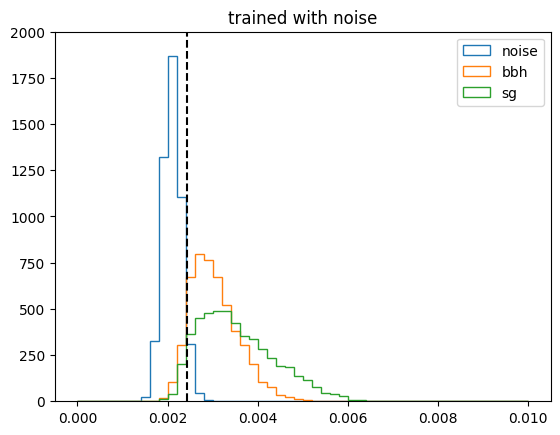

In [141]:
model = models['noise']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

In [147]:
model

WSClassifier(
  (fc1): Linear(in_features=202, out_features=32, bias=True)
  (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=32, out_features=1, bias=True)
)

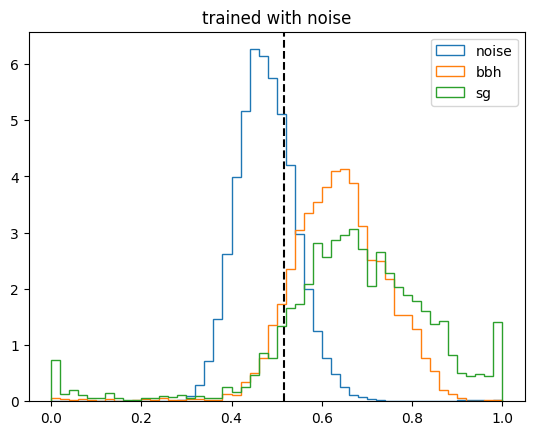

In [146]:
model = models['noise_WSC']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

In [135]:
listResult['FPR']

array([[0.00560376],
       [0.01588806],
       [0.02525922],
       [0.07428777],
       [0.29004525],
       [0.00577879],
       [0.01164927],
       [0.02279853],
       [0.04604085],
       [0.27701613],
       [0.00392454],
       [0.0139595 ],
       [0.02496768],
       [0.04971686],
       [0.27548517],
       [0.00623608],
       [0.0083835 ],
       [0.02873179],
       [0.14465073],
       [0.30256365],
       [0.00623664],
       [0.01376821],
       [0.02466388],
       [0.08350033],
       [0.14796328]])

In [155]:
listResult['FPR'].min()

0.003924541765151853

In [151]:
listResult['FPR'][np.argwhere(listResult['cut'] == [2,0]).flatten()]

array([], shape=(0, 1), dtype=float64)

In [138]:
listResult['FPR']

array([[0.0382321 ],
       [0.03678628],
       [0.03791166],
       [0.0369185 ],
       [0.03972851],
       [0.03664382],
       [0.03754649],
       [0.03628057],
       [0.03802401],
       [0.03817204],
       [0.0379521 ],
       [0.04192311],
       [0.03758527],
       [0.03910465],
       [0.03774258],
       [0.03995546],
       [0.0367893 ],
       [0.03808633],
       [0.03779885],
       [0.03760904],
       [0.03973628],
       [0.03720536],
       [0.03948891],
       [0.04333111],
       [0.03725822]])

In [104]:
135 / 22500

0.006

In [115]:
cutList

{'glitch': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'noise': array([0.0026, 0.0024, 0.0022, 0.002 , 0.0018]),
 'bbh': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'sg': array([0.0032, 0.0026, 0.002 , 0.0014, 0.0008])}

Text(0, 0.5, 'percentage')

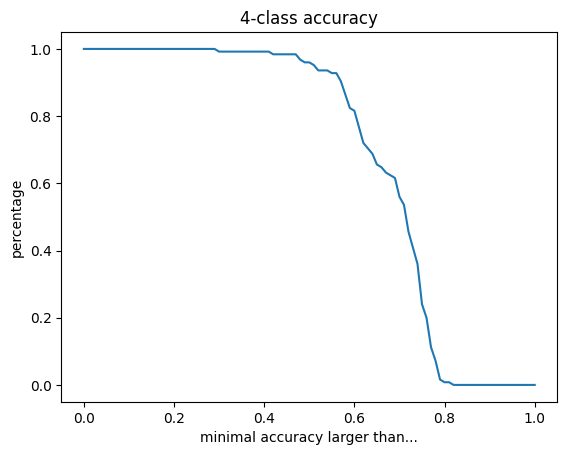

In [81]:
foo = np.array([ [0.01*A, np.sum(np.all(listResult["accuracy_4"] >= 0.01*A, axis=1))/len(listResult["accuracy_4"])] for A in range(101)])
plt.plot(foo[:, 0], foo[:, 1])
plt.title('4-class accuracy')
plt.xlabel('minimal accuracy larger than...')
plt.ylabel('percentage')

In [83]:
listResult["accuracy_4"][np.argwhere(np.all(listResult["accuracy_4"]>0.8, axis=1)).flatten()]

array([[0.998     , 0.94366667, 0.95925   , 0.81125   ]])

Text(0, 0.5, 'percentage')

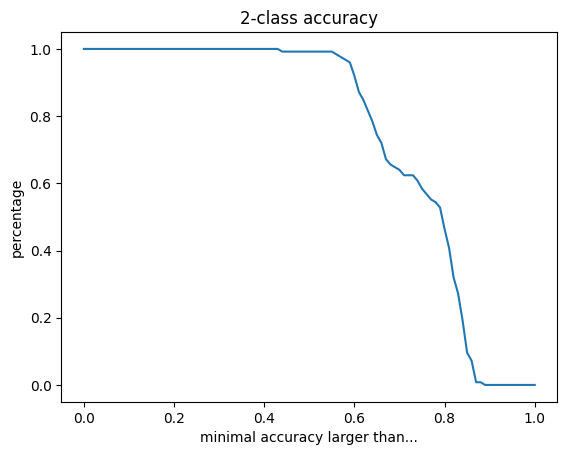

In [82]:
foo = np.array([ [0.01*A, np.sum(np.all(listResult["accuracy_2"] >= 0.01*A, axis=1))/len(listResult["accuracy_2"])] for A in range(101)])
plt.plot(foo[:, 0], foo[:, 1])
plt.title('2-class accuracy')
plt.xlabel('minimal accuracy larger than...')
plt.ylabel('percentage')

In [84]:
listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset)

In [87]:
listResult['total_accuracy'].max()

0.96345

In [88]:
listResult["accuracy_4"][np.argmax(listResult["accuracy_4"]>0.8).flatten()]

array([[0.999     , 0.95303333, 0.91975   , 0.69625   ]])

In [66]:
np.argwhere(np.all(np.array(list(itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)))) == np.array([3,1,3]), axis = 1))

array([[83]], dtype=int64)

In [62]:
np.array(list(itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut))))

array([[0, 0, 0],
       [0, 0, 1],
       [0, 0, 2],
       [0, 0, 3],
       [0, 0, 4],
       [0, 1, 0],
       [0, 1, 1],
       [0, 1, 2],
       [0, 1, 3],
       [0, 1, 4],
       [0, 2, 0],
       [0, 2, 1],
       [0, 2, 2],
       [0, 2, 3],
       [0, 2, 4],
       [0, 3, 0],
       [0, 3, 1],
       [0, 3, 2],
       [0, 3, 3],
       [0, 3, 4],
       [0, 4, 0],
       [0, 4, 1],
       [0, 4, 2],
       [0, 4, 3],
       [0, 4, 4],
       [1, 0, 0],
       [1, 0, 1],
       [1, 0, 2],
       [1, 0, 3],
       [1, 0, 4],
       [1, 1, 0],
       [1, 1, 1],
       [1, 1, 2],
       [1, 1, 3],
       [1, 1, 4],
       [1, 2, 0],
       [1, 2, 1],
       [1, 2, 2],
       [1, 2, 3],
       [1, 2, 4],
       [1, 3, 0],
       [1, 3, 1],
       [1, 3, 2],
       [1, 3, 3],
       [1, 3, 4],
       [1, 4, 0],
       [1, 4, 1],
       [1, 4, 2],
       [1, 4, 3],
       [1, 4, 4],
       [2, 0, 0],
       [2, 0, 1],
       [2, 0, 2],
       [2, 0, 3],
       [2, 0, 4],
       [2,

In [73]:
ic

array([4, 4, 4, 4])

In [49]:
cutList

{'glitch': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'noise': array([0.0026 , 0.00235, 0.0021 , 0.00185, 0.0016 ]),
 'bbh': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'sg': array([0.0032, 0.0026, 0.002 , 0.0014, 0.0008])}

# Result for Chia-Jui noise trained model

In [64]:
testset = dataset_wsl_fft_collected

In [ ]:
testset = dataset_reserved_test_collected

In [49]:
testset.shape

(3000, 202)

In [50]:
correct_ans = np.hstack(([0]*N_wsl['glitch'], [1]*N_wsl['noise'], [2]*N_wsl['bbh'], [3]*N_wsl['sg']))

In [65]:
correct_ans_withoutsignal = np.hstack(([0]*N_wsl['glitch'], [1]*N_wsl['noise'], [-1]*(N_wsl['bbh']+N_wsl['sg'])))

In [ ]:
correct_ans_withoutsignal = np.hstack(([0]*N_reserved_test['glitch'], [1]*N_reserved_test['noise'], [2]*N_reserved_test['bbh'], [3]*N_reserved_test['sg']))

In [66]:
correct_ans.shape

NameError: name 'correct_ans' is not defined

In [67]:
correct_ans_withoutsignal.shape

(3000,)

In [68]:
ic[3] = 0

NameError: name 'ic' is not defined

In [69]:
list_datatype_withoutsignal = ["noise", "glitch"]

In [70]:
ic_withoutsignal = np.array([0,0])

In [73]:
Ncut = 5

In [76]:
listResult = {};
listResult["cut"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)), dtype="int");
listResult["ans"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(testset)), dtype="int");
listResult["accuracy_4"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), len(list_datatype_withoutsignal)))
listResult["accuracy_2"] = np.empty((Ncut**(len(list_datatype_withoutsignal)), 2))
cnt = 0

listResult["FPR"] = np.empty((Ncut**(len(list_datatype_withoutsignal)),1))


for ic_withoutsignal[0], ic_withoutsignal[1] in itertools.product(np.arange(Ncut), np.arange(Ncut)):

    
    # if cnt < 86:
    #     continue
    
    t0 = time.time()
    data_filtered = {};
    for dt in sequence:
        data_filtered[dt] = dataset_ae_fft[dt]
#     data_filtered["noise"] = bkg_fft;
#     data_filtered["bbh"] = bbh_fft;
#     data_filtered["sg"] = sg_fft;

    dataset_wsl_filtered = dataset_wsl_fft_collected
    
    cutID = "".join(str(ic[j]) for j in range(3)) + "_"+version
        
#     for iPrev in range(3):
#         previousStep = ind2datatype[iPrev];
#         modelPrev = models[previousStep]; # previous step AE
        
#         # train the WSC according to previous AE's cut
        
#         dataset0 = data_filtered[previousStep] # here they haven't been updated yet
        
#         dcd = modelPrev(torch.FloatTensor(dataset0))[1].detach().numpy();
#         dataset1 = dataset0[np.var(dataset0-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         dcd = modelPrev(torch.FloatTensor(dataset_wsl_filtered))[1].detach().numpy();
#         dataset1 = dataset_wsl_filtered[np.var(dataset_wsl_filtered-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]
        
#         model = trainWSC(dataset0, dataset1, cutID)
#         models[previousStep+"_WSC"] = model;
        
#         # filter the data according to previous WSC
#         for j in range(iPrev, 4):
#             dt = ind2datatype[j];
#             dcd = nn.Sigmoid()(model(torch.FloatTensor(data_filtered[dt]))).detach().numpy().flatten();
#             data_filtered[dt] = data_filtered[dt][dcd>0.5]
        
# #         # filter the data
# #         for j in range(iPrev+1, 4):
# #             dt = ind2datatype[j];
# #             dcd = modelPrev(torch.FloatTensor(data_filtered[dt]))[1].detach().numpy()
# #             data_filtered[dt] = data_filtered[dt][np.var(data_filtered[dt]-dcd, axis=1) >= cutList[previousStep][ic[iPrev]]]            
        
#         # train the current step AE
#         currentStep = ind2datatype[iPrev+1];
#         model = trainAE(data_filtered[currentStep], cutID);
#         models[currentStep] = model;
        
#     torch.save(models, "../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(3)) + "_"+version+".json")
#     print(models.keys())
    
    models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic_withoutsignal[j]) for j in range(2)) + "_"+version+".json")
    # print("../Data_cached/SequentialTraining/WSL/trained_model" + "".join(str(ic[j]) for j in range(2)) + "_"+version+".json")
    dcd = {};
    err = {};
    ans = np.zeros(len(testset), dtype="int")
    
    for datatype in list_datatype_withoutsignal:
        if datatype == 'sg':
            dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
            err[datatype] = np.var(testset-dcd[datatype], axis=1)
        
        # elif datatype == 'noise':
        #     dcd[datatype] = models[datatype](torch.FloatTensor(testset))[1].detach().numpy()
        #     err[datatype] = np.var(testset-dcd[datatype], axis=1)
            
        else:
            dcd[datatype] = nn.Sigmoid()(models[datatype + "_WSC"](torch.FloatTensor(testset))).detach().numpy().reshape(-1)
        
    not_select = np.array([True]*len(testset));

    # for iStep in range(len(list_datatype_withoutsignal)):
    #     datatype = ind2datatype[iStep];
    #     if datatype == 'sg':
    #         ind_pass = np.logical_and(not_select, err[datatype] <= cutList[datatype][ic[iStep]]);
    #     else:
    #         ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5);
    #     ans[ind_pass] = iStep;
    #     not_select[ind_pass] = False;
        
    # Pass glitch first
    
    datatype = 'glitch'
    ind_pass = np.logical_and(not_select, dcd[datatype] <= 0.5)
    ans[ind_pass] = 0;
    not_select[ind_pass] = False;
    # print(dcd['glitch'])
    
    # Leftover are noise and signals
    
    datatype = 'noise'
    ind_pass = np.logical_and(not_select, dcd[datatype] <= np.sort(dcd[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
    # ind_pass = np.logical_and(not_select, err[datatype] <= np.sort(err[datatype][-N_wsl['bbh']-N_wsl['sg']:])[int(0.1 * (N_wsl['bbh']+N_wsl['sg']))])
    noise_number = np.sum(np.logical_and(not_select, correct_ans_withoutsignal == 1))
    passed_noise_number = noise_number - np.sum(np.logical_and(ind_pass, correct_ans_withoutsignal == 1))
    ans[ind_pass] = 1;
    not_select[ind_pass] = False;
    
    ans[not_select] = -1
    
    FPR = passed_noise_number / noise_number
    
    # print(dcd['noise'])
    print('For cnt = {}, totally {} noise events passed the glitch WSL, and {} noise events within the threshold for TPR=0.9'.format(cnt, noise_number, passed_noise_number))
    listResult['FPR'][cnt] = FPR
    listResult['cut'][cnt] = ic_withoutsignal
        
    # ans[not_select] = -1;

    # listResult["cut"][cnt] = ic_withoutsignal;
    # listResult["ans"][cnt] = ans;

    # acc = np.zeros(len(ind2datatype));

    # for i in range(len(ind2datatype)):
    #     acc[i] = np.sum(np.logical_and(ans==i, correct_ans_withoutsignal==i))/N_wsl[ind2datatype[i]];
        
    # listResult["accuracy_4"][cnt] = acc;

    # listResult["accuracy_2"][cnt] = [ np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["glitch", "noise"])/np.sum(N_wsl[dtype] for dtype in ["glitch", "noise"]), 
    #                                     np.sum(acc[datatype2ind[dtype]]*N_wsl[dtype] for dtype in ["bbh", "sg"])/np.sum(N_wsl[dtype] for dtype in ["bbh", "sg"])]

    cnt += 1;

NameError: name 'ic' is not defined

In [61]:
listResult['FPR']

array([[0.5395189 ],
       [0.6257485 ],
       [0.97066667],
       [0.97749196],
       [0.96601942],
       [0.76397516],
       [0.79538217],
       [0.85144928],
       [0.80729167],
       [0.82121212],
       [0.72485962],
       [0.74706183],
       [0.84575569],
       [0.94507772],
       [0.96520424],
       [0.75650118],
       [0.72650376],
       [0.84892086],
       [0.95040534],
       [0.97270588],
       [0.73227969],
       [0.87494167],
       [0.84670147],
       [0.93411765],
       [0.97877358]])

In [62]:
# This is the result for 0.05, 0.65, 0.15, 0.15

print(listResult['cut'][np.argmin(listResult['FPR'])])
print(listResult['FPR'].min())

[0 0]
0.5395189003436426


In [ ]:
# This is the result for 0.1, 0.3, 0.3, 0.3

print(listResult['cut'][np.argmin(listResult['FPR'])])
print(listResult['FPR'].min())

[4 0]
0.003848084323239083


In [ ]:
np.argwhere(ans[-6000:] == 1).shape

(597, 1)

In [ ]:
N_wsl['noise']

22500

In [ ]:
np.argwhere(ans[1500:-6000] == 1).shape

(19118, 1)

In [ ]:
np.argwhere(ans[1500:-6000] == -1).shape

(3320, 1)

In [ ]:
np.argwhere(ans[-6000:] == -1).shape

(5398, 1)

In [ ]:
np.argwhere(ans[1500:-6000] == -1).shape

(135, 1)

In [77]:
models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "00" + "_"+version+".json")

In [84]:
models = torch.load("../Data_cached/SequentialTraining/WSL/trained_model" + "00" + "_v6.json")

In [64]:
dataset_wsl_fft

{'noise': array([[3.75803461e-02, 5.19980410e-02, 7.11897231e-02, ...,
         5.70335581e-03, 5.66126335e-03, 5.66705806e-03],
        [5.11109784e-03, 2.90017348e-02, 6.21384329e-02, ...,
         5.31911077e-03, 5.28157705e-03, 5.30578589e-03],
        [2.67082197e-02, 3.85819943e-02, 2.05402769e-02, ...,
         7.47662214e-03, 7.44311073e-03, 7.42143186e-03],
        ...,
        [3.61762312e-02, 4.94204426e-02, 2.43239822e-02, ...,
         5.79947266e-04, 3.12861138e-04, 5.83874447e-05],
        [7.07041750e-03, 1.06595149e-02, 8.05424030e-02, ...,
         1.02448389e-02, 1.02258828e-02, 1.01878053e-02],
        [3.28809822e-02, 4.43646698e-02, 2.00710775e-02, ...,
         3.62308188e-03, 3.62523057e-03, 3.64992646e-03]]),
 'bbh': array([[7.57095507e-02, 8.49995596e-02, 1.87917767e-01, ...,
         9.56477804e-03, 9.59237338e-03, 9.53138379e-03],
        [4.18299326e-03, 3.26492974e-02, 1.64341977e-01, ...,
         9.86156797e-03, 9.92180863e-03, 9.95067674e-03],
        [

(0.0, 2000.0)

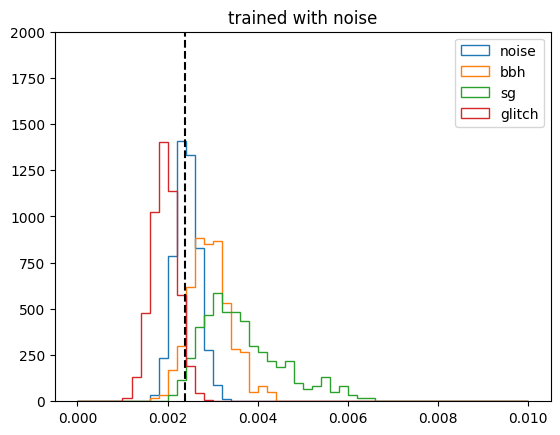

In [90]:
model = models['glitch']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

(0.0, 2000.0)

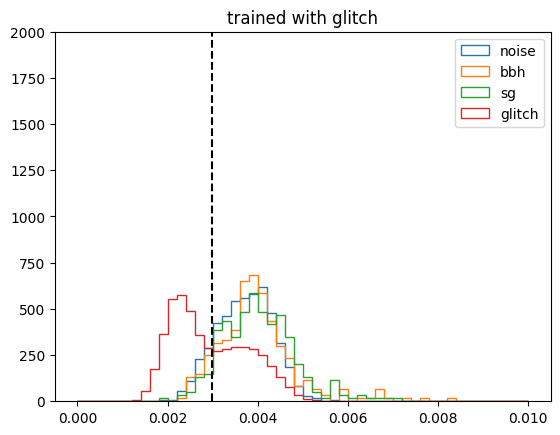

In [43]:
# Chia-Jui data + GWAK model

model = models['glitch']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

(0.0, 2000.0)

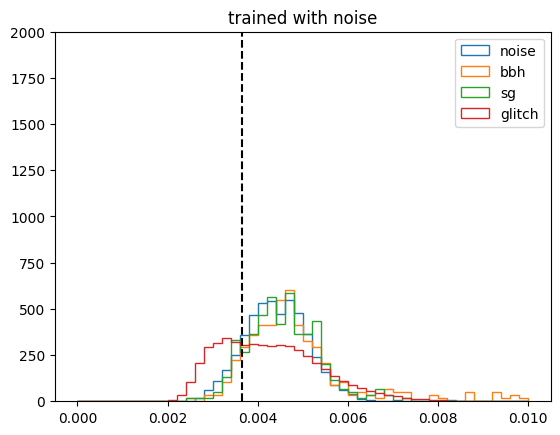

In [89]:
# Chia-Jui data + GWAK model

model = models['noise']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

(0.0, 2000.0)

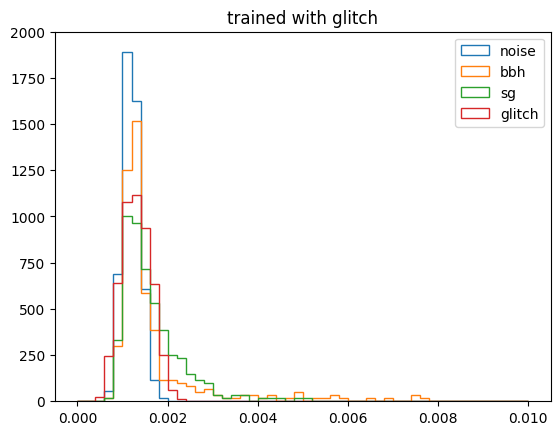

In [82]:
model = models['glitch']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
# plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

In [83]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=202, out_features=20, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=202, bias=True)
    (1): Sigmoid()
  )
)

(0.0, 2000.0)

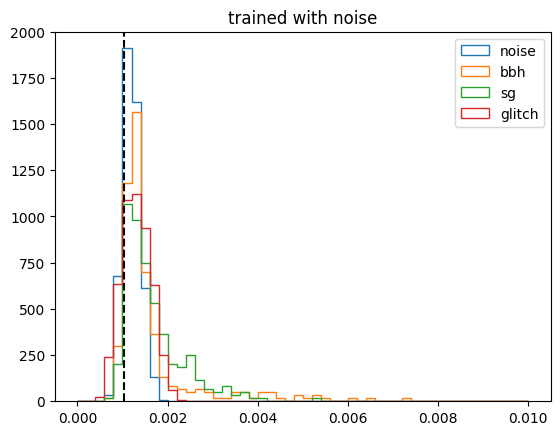

In [110]:
model = models['glitch']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

(0.0, 2000.0)

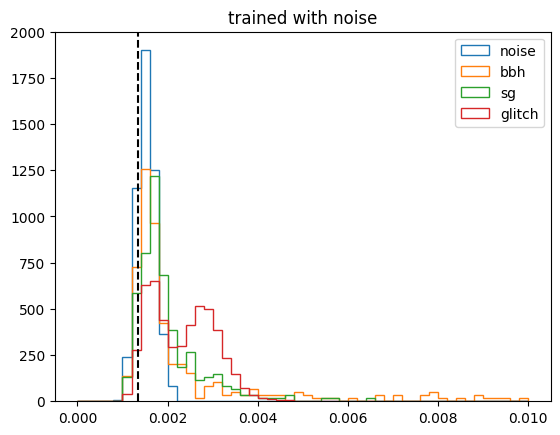

In [80]:
model = models['noise']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

(0.0, 2000.0)

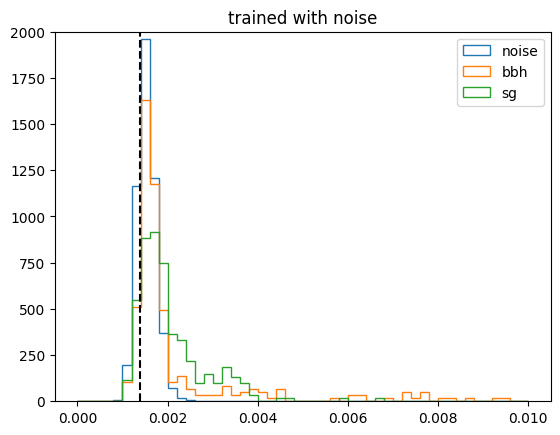

In [65]:
model = models['noise']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = model(torch.FloatTensor(bkg_filtered))[1].detach().numpy()
dcd_bbh = model(torch.FloatTensor(bbh_filtered))[1].detach().numpy()
dcd_sg = model(torch.FloatTensor(sg_filtered))[1].detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(np.var(bbh_filtered-dcd_bbh, axis=1))[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
plt.ylim(0,2000)

In [66]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=202, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=10, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=20, bias=True)
    (1): ReLU()
    (2): Linear(in_features=20, out_features=202, bias=True)
    (3): Sigmoid()
  )
)

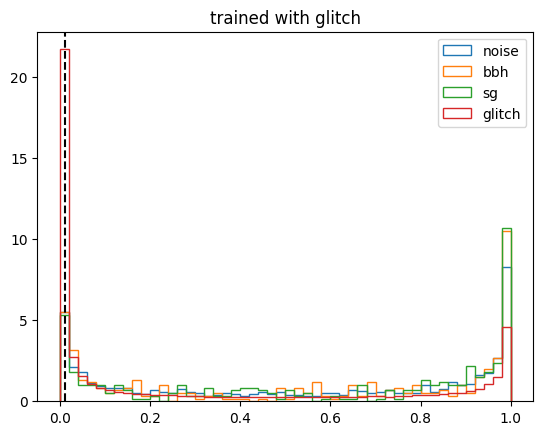

In [94]:
# Chia-Jui data + GWAK model

model = models['glitch_WSC']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']


# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_fft))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
plt.title("trained with glitch")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

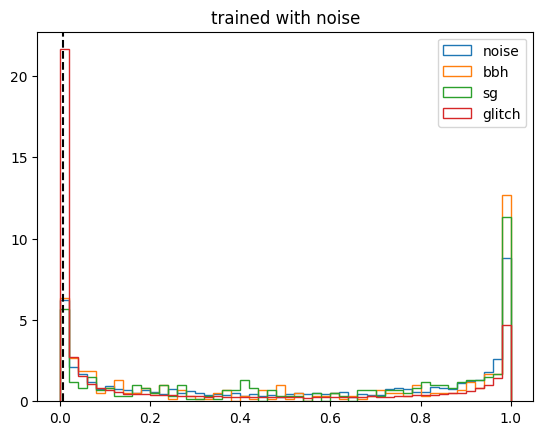

In [44]:
# Chia-Jui data + GWAK model

model = models['glitch_WSC']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']


# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_fft))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

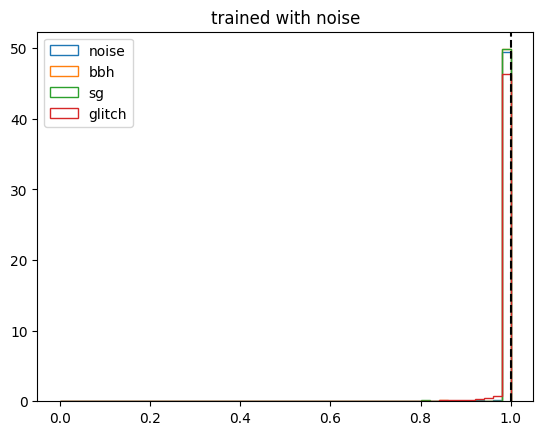

In [92]:
# Chia-Jui data + GWAK model

model = models['noise_WSC']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']


# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_fft))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

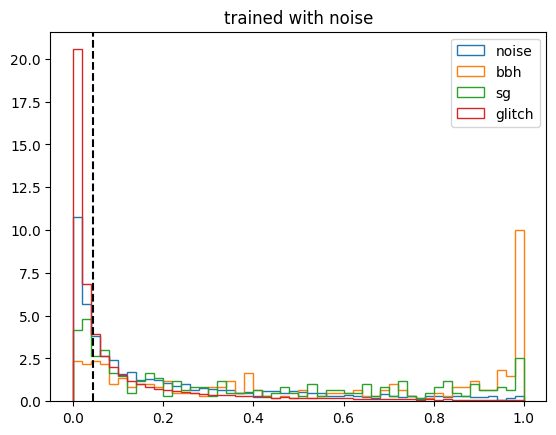

In [78]:
# Chia-Jui data + Chia-Jui model

model = models['glitch_WSC']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']


# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
dcd_glitch = nn.Sigmoid()(model(torch.FloatTensor(glitch_fft))).detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
foo = plt.hist(dcd_glitch, histtype="step", range=(0, 1), bins=50, density=True, label="glitch")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

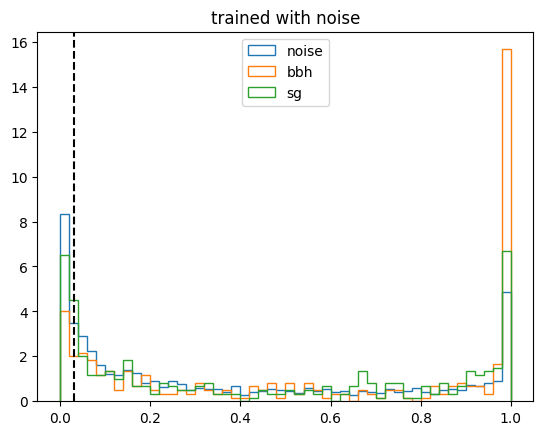

In [67]:
model = models['noise_WSC']

bkg_filtered = dataset_wsl_fft['noise']
bbh_filtered = dataset_wsl_fft['bbh']
sg_filtered = dataset_wsl_fft['sg']

# c0[currentStep] = 0.0022;

dcd_bkg = nn.Sigmoid()(model(torch.FloatTensor(bkg_filtered))).detach().numpy()
dcd_bbh = nn.Sigmoid()(model(torch.FloatTensor(bbh_filtered))).detach().numpy()
dcd_sg = nn.Sigmoid()(model(torch.FloatTensor(sg_filtered))).detach().numpy()
# dcd_glitch = model(torch.FloatTensor(glitch_fft))[1].detach().numpy()

# foo = plt.hist(np.var(bkg_filtered-dcd_bkg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="noise")
# foo = plt.hist(np.var(bbh_filtered-dcd_bbh, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="bbh")
# foo = plt.hist(np.var(sg_filtered-dcd_sg, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="sg")
# foo = plt.hist(np.var(glitch_fft-dcd_glitch, axis=1), histtype="step", range=(0, 0.01), bins=50, density=True, label="glitch")
foo = plt.hist(dcd_bkg, histtype="step", range=(0, 1), bins=50, density=True, label="noise")
foo = plt.hist(dcd_bbh, histtype="step", range=(0, 1), bins=50, density=True, label="bbh")
foo = plt.hist(dcd_sg, histtype="step", range=(0, 1), bins=50, density=True, label="sg")
plt.title("trained with noise")
# plt.axvline(c0[currentStep], color="k", linestyle="--")
plt.axvline(np.sort(dcd_bbh.flatten())[int(0.1 * len(bbh_filtered))], color = 'k', linestyle = '--')
plt.legend()
# plt.ylim(0,2000)

In [ ]:
listResult['FPR']

array([[0.00560376],
       [0.01588806],
       [0.02525922],
       [0.07428777],
       [0.29004525],
       [0.00577879],
       [0.01164927],
       [0.02279853],
       [0.04604085],
       [0.27701613],
       [0.00392454],
       [0.0139595 ],
       [0.02496768],
       [0.04971686],
       [0.27548517],
       [0.00623608],
       [0.0083835 ],
       [0.02873179],
       [0.14465073],
       [0.30256365],
       [0.00623664],
       [0.01376821],
       [0.02466388],
       [0.08350033],
       [0.14796328]])

In [ ]:
listResult['FPR'].min()

0.003924541765151853

In [ ]:
listResult['FPR'][np.argwhere(listResult['cut'] == [2,0]).flatten()]

array([], shape=(0, 1), dtype=float64)

In [ ]:
listResult['FPR']

array([[0.0382321 ],
       [0.03678628],
       [0.03791166],
       [0.0369185 ],
       [0.03972851],
       [0.03664382],
       [0.03754649],
       [0.03628057],
       [0.03802401],
       [0.03817204],
       [0.0379521 ],
       [0.04192311],
       [0.03758527],
       [0.03910465],
       [0.03774258],
       [0.03995546],
       [0.0367893 ],
       [0.03808633],
       [0.03779885],
       [0.03760904],
       [0.03973628],
       [0.03720536],
       [0.03948891],
       [0.04333111],
       [0.03725822]])

In [ ]:
135 / 22500

0.006

In [ ]:
cutList

{'glitch': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'noise': array([0.0026, 0.0024, 0.0022, 0.002 , 0.0018]),
 'bbh': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'sg': array([0.0032, 0.0026, 0.002 , 0.0014, 0.0008])}

Text(0, 0.5, 'percentage')

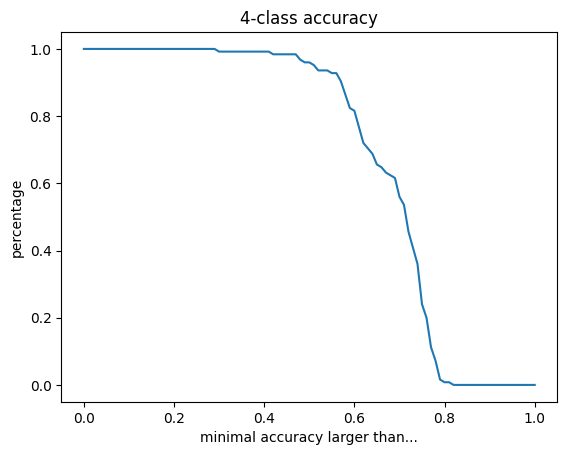

In [ ]:
foo = np.array([ [0.01*A, np.sum(np.all(listResult["accuracy_4"] >= 0.01*A, axis=1))/len(listResult["accuracy_4"])] for A in range(101)])
plt.plot(foo[:, 0], foo[:, 1])
plt.title('4-class accuracy')
plt.xlabel('minimal accuracy larger than...')
plt.ylabel('percentage')

In [ ]:
listResult["accuracy_4"][np.argwhere(np.all(listResult["accuracy_4"]>0.8, axis=1)).flatten()]

array([[0.998     , 0.94366667, 0.95925   , 0.81125   ]])

Text(0, 0.5, 'percentage')

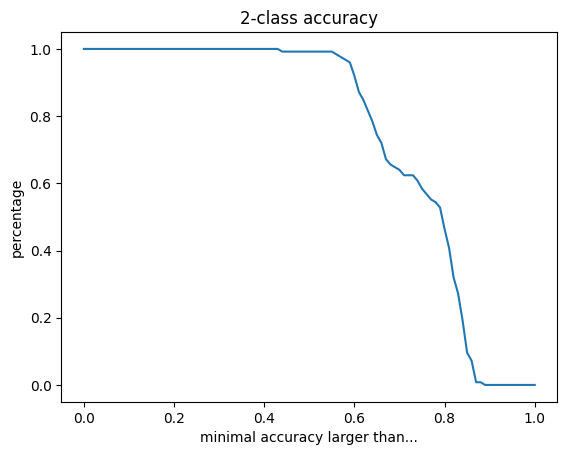

In [ ]:
foo = np.array([ [0.01*A, np.sum(np.all(listResult["accuracy_2"] >= 0.01*A, axis=1))/len(listResult["accuracy_2"])] for A in range(101)])
plt.plot(foo[:, 0], foo[:, 1])
plt.title('2-class accuracy')
plt.xlabel('minimal accuracy larger than...')
plt.ylabel('percentage')

In [ ]:
listResult["total_accuracy"] = np.sum(listResult["ans"]==correct_ans, axis=1)/len(testset)

In [ ]:
listResult['total_accuracy'].max()

0.96345

In [ ]:
listResult["accuracy_4"][np.argmax(listResult["accuracy_4"]>0.8).flatten()]

array([[0.999     , 0.95303333, 0.91975   , 0.69625   ]])

In [ ]:
np.argwhere(np.all(np.array(list(itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut)))) == np.array([3,1,3]), axis = 1))

array([[83]], dtype=int64)

In [ ]:
np.array(list(itertools.product(np.arange(Ncut), np.arange(Ncut), np.arange(Ncut))))

array([[0, 0, 0],
       [0, 0, 1],
       [0, 0, 2],
       [0, 0, 3],
       [0, 0, 4],
       [0, 1, 0],
       [0, 1, 1],
       [0, 1, 2],
       [0, 1, 3],
       [0, 1, 4],
       [0, 2, 0],
       [0, 2, 1],
       [0, 2, 2],
       [0, 2, 3],
       [0, 2, 4],
       [0, 3, 0],
       [0, 3, 1],
       [0, 3, 2],
       [0, 3, 3],
       [0, 3, 4],
       [0, 4, 0],
       [0, 4, 1],
       [0, 4, 2],
       [0, 4, 3],
       [0, 4, 4],
       [1, 0, 0],
       [1, 0, 1],
       [1, 0, 2],
       [1, 0, 3],
       [1, 0, 4],
       [1, 1, 0],
       [1, 1, 1],
       [1, 1, 2],
       [1, 1, 3],
       [1, 1, 4],
       [1, 2, 0],
       [1, 2, 1],
       [1, 2, 2],
       [1, 2, 3],
       [1, 2, 4],
       [1, 3, 0],
       [1, 3, 1],
       [1, 3, 2],
       [1, 3, 3],
       [1, 3, 4],
       [1, 4, 0],
       [1, 4, 1],
       [1, 4, 2],
       [1, 4, 3],
       [1, 4, 4],
       [2, 0, 0],
       [2, 0, 1],
       [2, 0, 2],
       [2, 0, 3],
       [2, 0, 4],
       [2,

In [ ]:
ic

array([4, 4, 4, 4])

In [ ]:
cutList

{'glitch': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'noise': array([0.0026 , 0.00235, 0.0021 , 0.00185, 0.0016 ]),
 'bbh': array([0.0024 , 0.00215, 0.0019 , 0.00165, 0.0014 ]),
 'sg': array([0.0032, 0.0026, 0.002 , 0.0014, 0.0008])}